--- RUNNING IN DRY RUN MODE (QUICK TEST) ---
Loading simulated data from: ../data/train_v4.hdf5
  - Loaded SNR -30.0: (15000, 16, 120, 7)
  - Loaded SNR -27.5: (15000, 16, 120, 7)
  - Loaded SNR -25.0: (15000, 16, 120, 7)
  - Loaded SNR -22.5: (15000, 16, 120, 7)
  - Loaded SNR -20.0: (15000, 16, 120, 7)
  - Loaded SNR -17.5: (15000, 16, 120, 7)
  - Loaded SNR -15.0: (15000, 16, 120, 7)
  - Loaded SNR -12.5: (15000, 16, 120, 7)
  - Loaded SNR -10.0: (15000, 16, 120, 7)
  - Loaded SNR -7.5: (15000, 16, 120, 7)
  - Loaded SNR -5.0: (15000, 16, 120, 7)
  - Loaded SNR -2.5: (15000, 16, 120, 7)
  - Loaded SNR 0.0: (15000, 16, 120, 7)
  - Loaded SNR 2.5: (15000, 16, 120, 7)
  - Loaded SNR 5.0: (15000, 16, 120, 7)

Loading experimental data from: ../data/experimental_features.hdf5
  - Loaded and Formatted Intensity 30 dB: (5278, 16, 1, 7)
  - Loaded and Formatted Intensity 40 dB: (5257, 16, 1, 7)
  - Loaded and Formatted Intensity 50 dB: (3276, 16, 1, 7)
  - Loaded and Formatted Intensity 60 

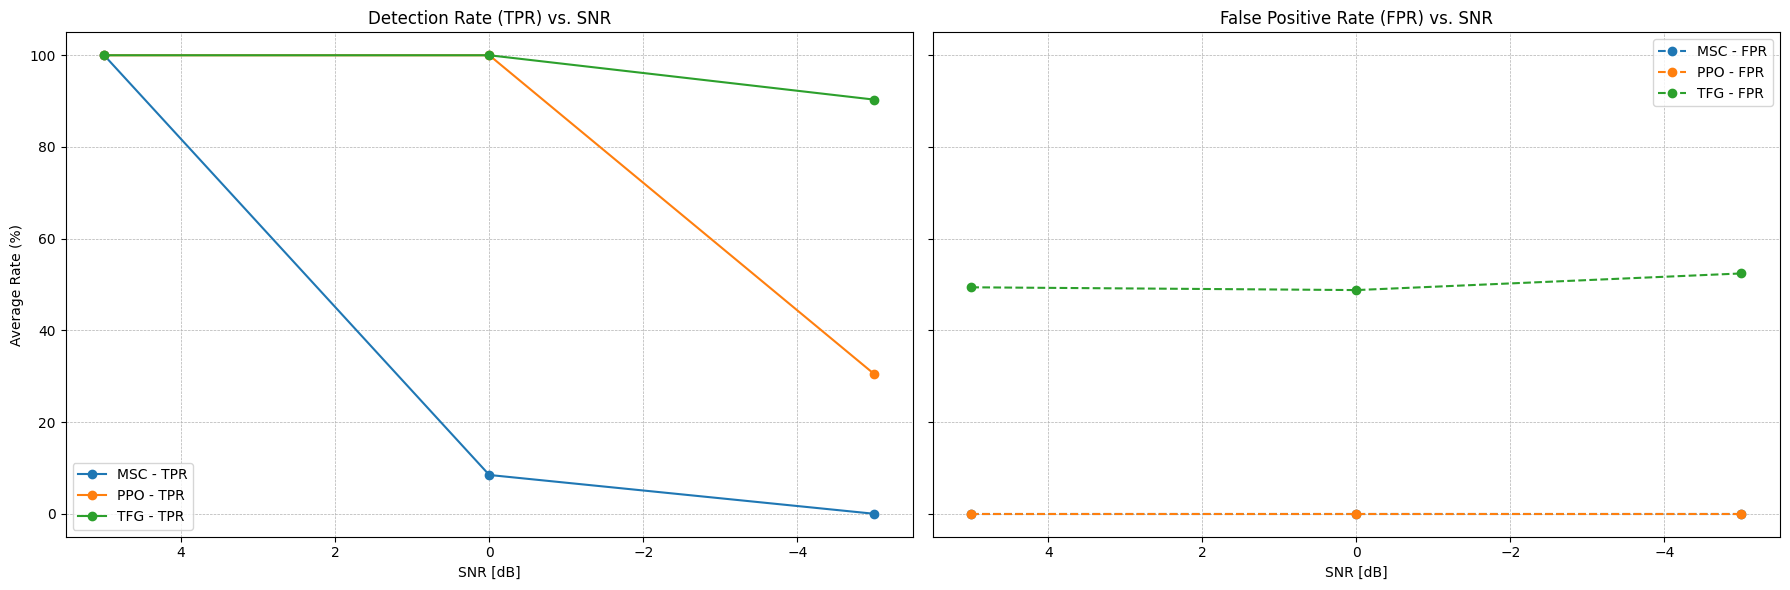

In [ ]:
# -*- coding: utf-8 -*-
"""
Refactored Notebook v21 for PPO Model Training with 4D and 3D Data.

This final version adds robustness to loading experimental data. It detects
if the experimental data is 3D (trials, freqs, features) and, if so,
adds a 'windows' dimension of size 1 to make it 4D. This ensures
that both simulated and experimental data have a consistent 4D format,
resolving the `ValueError` during the experimental evaluation phase.
"""

# %% [markdown]
# # PPO Model Training with Pre-Calculated Features (v21)
#
# # This notebook trains a PPO model and robustly handles simulation (4D) and experimental (3D) data, ensuring format consistency.

# %% [code]
# Essential imports
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import torch as th
import matplotlib.pyplot as plt
import h5py
import warnings
import re
from datetime import datetime

# Ignore some common warnings to keep the output clean
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice.")


# %% [markdown]
# ## Control Parameters

# %% [code]
# #####################################################################
# EXECUTION MODE AND GLOBAL PARAMETERS
# #####################################################################
DRY_RUN = True # Change to False for a full run

if DRY_RUN:
    print("--- RUNNING IN DRY RUN MODE (QUICK TEST) ---")
    TOTAL_TRAINING_TIMESTEPS, EVAL_SIM_TIMESTEPS = 2500, 1000
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 5, 10
else:
    print("--- RUNNING IN FULL MODE ---")
    TOTAL_TRAINING_TIMESTEPS, EVAL_SIM_TIMESTEPS = 500, 500
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 25, 50

# #####################################################################
# PATHS AND CONSTANTS
# #####################################################################
FEATURE_NAMES = ['MSC', 'CSM', 'TFG', 'TFL', 'SNR_meas', 'MAG_freq', 'PHI_freq']
NUM_RAW_FEATURES = len(FEATURE_NAMES)
NUM_SIGNAL_FREQS = 8 # Number of frequencies that contain a signal
MODELS_TO_EVALUATE = ['PPO', 'MSC', 'TFG'] # Models to include in the evaluation

HDF5_SIMULATED_FILEPATH = '../data/train_v4.hdf5'
EXPERIMENTAL_FEATURES_FILE = '../data/experimental_features.hdf5'


# %% [markdown]
# ## Data Loading and Preparation (HDF5)

# %% [code]
def load_and_adapt_hdf5_data(sim_path, exp_path):
    """
    Loads HDF5 data and ensures all output datasets have the 4D format
    (trials, freqs, windows, features).
    """
    simulated_c_states = {}
    experimental_c_states = {}

    print(f"Loading simulated data from: {sim_path}")
    try:
        with h5py.File(sim_path, 'r') as f:
            snr_keys = sorted([key for key in f.keys() if 'snr' in key], key=lambda x: float(x.split('_')[1]))
            for key in snr_keys:
                snr_val = float(key.split('_')[1])
                data_4d = f[key]['metrics'][:]
                simulated_c_states[snr_val] = data_4d.transpose(0, 2, 1, 3)
                print(f"  - Loaded SNR {snr_val}: {simulated_c_states[snr_val].shape}")

    except FileNotFoundError:
        print(f"Warning: Simulated data file '{sim_path}' not found. Training will be skipped.")
    except Exception as e:
        print(f"Error loading simulated data: {e}")


    print(f"\nLoading experimental data from: {exp_path}")
    try:
        with h5py.File(exp_path, 'r') as f:
            temp_experimental_data = {}
            for volunteer in f.keys():
                for intensity_key in f[volunteer].keys():
                    intensity_val_match = re.search(r'(\d+)', intensity_key)
                    if not intensity_val_match: continue
                    intensity_val = int(intensity_val_match.group(1))
                    data = f[volunteer][intensity_key]['metrics'][:]
                    if intensity_val in temp_experimental_data:
                        temp_experimental_data[intensity_val].append(data)
                    else:
                        temp_experimental_data[intensity_val] = [data]

            for intensity, data_list in temp_experimental_data.items():
                combined_data = np.concatenate(data_list, axis=0)
                
                # #####################################################################
                # FIX: Ensure experimental data is also 4D
                # #####################################################################
                if combined_data.ndim == 3:
                    # Add the missing 'windows' dimension.
                    # Format changes from (trials, freqs, features) to (trials, freqs, 1, features)
                    combined_data = np.expand_dims(combined_data, axis=2)
                # #####################################################################
                
                experimental_c_states[intensity] = combined_data
                print(f"  - Loaded and Formatted Intensity {intensity} dB: {combined_data.shape}")

    except FileNotFoundError:
        print(f"Warning: Experimental data file '{exp_path}' not found. Experimental evaluation will be skipped.")
    except Exception as e:
        print(f"Error loading experimental data: {e}")

    return simulated_c_states, experimental_c_states

simulated_c_states, experimental_c_states = load_and_adapt_hdf5_data(
    HDF5_SIMULATED_FILEPATH, EXPERIMENTAL_FEATURES_FILE
)

def clean_data_dict(data_dict):
    """Replaces NaNs and Infs with 0.0 to prevent training errors."""
    cleaned_dict = {}
    for key, array in data_dict.items():
        if np.isnan(array).any() or np.isinf(array).any():
            print(f"Warning: Cleaning invalid values for key '{key}'.")
            cleaned_dict[key] = np.nan_to_num(array, nan=0.0, posinf=0.0, neginf=0.0)
        else:
            cleaned_dict[key] = array
    return cleaned_dict

print("\nValidating and cleaning data...")
simulated_c_states = clean_data_dict(simulated_c_states)
experimental_c_states = clean_data_dict(experimental_c_states)
print("Validation complete.")


# %% [markdown]
# ## Gymnasium Environments Aligned with 4D Data

# %% [code]
class CustomLoggingCallback(BaseCallback):
    """Callback for custom logs during training."""
    def __init__(self, log_freq: int, verbose=0):
        super().__init__(verbose)
        self.log_freq, self.episode_count = log_freq, 0
    def _on_step(self) -> bool:
        if any(self.locals["dones"]):
            self.episode_count += 1
            if self.episode_count % self.log_freq == 0 and self.logger.name_to_value:
                print(f"--- Library Logs (Episode {self.episode_count}) ---")
                for key, value in self.logger.name_to_value.items():
                    print(f"  {key}: {value:.4f}")
                print("---------------------------------------")
        return True

class SimTrainingEnv(gym.Env):
    """Training environment that uses the pre-calculated 4D data."""
    def __init__(self, data, verbose_level=0, verbose_freq=10):
        super().__init__()
        self.data = data # Expected format: (trials, freqs, windows, features)
        self.verbose_level, self.verbose_freq = verbose_level, verbose_freq
        
        self.num_trials, self.num_steps, self.num_windows, self.num_features = data.shape
        self.episode_count = -1

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.num_features,), dtype=np.float32
        )
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.episode_count += 1
        self.current_trial_idx = self.episode_count % self.num_trials
        self.current_step = 0
        self.current_trial_data = self.data[self.current_trial_idx, :, :, :]
        self.false_positives, self.true_positives = 0, 0
        return self._get_state(), {}

    def step(self, action):
        should_detect = self.current_step < NUM_SIGNAL_FREQS
        
        tp, fp, fn, tn = 0, 0, 0, 0
        if action == 1:
            if should_detect: self.true_positives += 1; tp = 1
            else: self.false_positives += 1; fp = 1
        else:
            if should_detect: fn = 1
            else: tn = 1
        
        reward = tp - fp 

        self.current_step += 1
        terminated = self.current_step >= self.num_steps
        info = {}

        if terminated:
            num_noise_freqs = self.num_steps - NUM_SIGNAL_FREQS
            tp_rate = 100 * self.true_positives / NUM_SIGNAL_FREQS if NUM_SIGNAL_FREQS > 0 else 0
            fp_rate = 100 * self.false_positives / num_noise_freqs if num_noise_freqs > 0 else 0
            
            reward = ((tp_rate / 100) ** 2) - ((fp_rate / 100) ** 2)
            
            info = {'tp_rate': round(tp_rate, 2), 'fp_rate': round(fp_rate, 2)}
            if self.verbose_level > 0 and self.episode_count % self.verbose_freq == 0:
                print(f"--- Environment Summary (Episode {self.episode_count}) ---")
                print(f"  Final TPR: {info.get('tp_rate',0):.2f}%, Final FPR: {info.get('fp_rate',0):.2f}%, Final Reward: {reward:.2f}")

        return self._get_state(), reward, terminated, False, info

    def _get_state(self):
        if self.current_step >= self.num_steps:
            return np.zeros(self.num_features, dtype=np.float32)
        return self.current_trial_data[self.current_step, -1, :]

class ExpEvaluationEnv(gym.Env):
    """Evaluation environment that accepts consistent 4D data."""
    def __init__(self, data):
        super().__init__()
        self.data = data # Expected format: (trials, freqs, windows, features)
        self.num_trials, self.num_steps, self.num_windows, self.num_features = data.shape
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.num_features,), dtype=np.float32
        )
        self.current_trial_idx = -1
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_trial_idx = (self.current_trial_idx + 1) % self.num_trials
        self.current_trial_data = self.data[self.current_trial_idx]
        self.current_step, self.true_positives, self.false_positives = 0, 0, 0
        return self._get_state(), self._get_info()

    def step(self, action):
        should_detect = self.current_step < NUM_SIGNAL_FREQS
        if action == 1:
            if should_detect: self.true_positives += 1
            else: self.false_positives += 1
        
        self.current_step += 1
        terminated = self.current_step >= self.num_steps
        reward = 1
        
        info = self._get_info() if terminated else {}
        return self._get_state(), reward, terminated, False, info

    def _get_state(self):
        if self.current_step >= self.num_steps:
            return np.zeros(self.num_features, dtype=np.float32)
        return self.current_trial_data[self.current_step, -1, :]

    def _get_info(self):
        num_noise_freqs = self.num_steps - NUM_SIGNAL_FREQS
        tp_rate = 100 * self.true_positives / NUM_SIGNAL_FREQS if NUM_SIGNAL_FREQS > 0 else 0
        fp_rate = 100 * self.false_positives / num_noise_freqs if num_noise_freqs > 0 else 0
        return {'tp_rate': tp_rate, 'fp_rate': fp_rate}


# %% [markdown]
# # 1. PPO Model Training
# %% [code]
def train_ppo_model(policy, data, timesteps, model_name, v_level, v_freq, log_freq):
    print("--- Training PPO model ---")
    env = DummyVecEnv([lambda: SimTrainingEnv(data, v_level, v_freq)])
    policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=dict(pi=[64, 64], vf=[64, 64]))
    model = PPO(policy, env, verbose=0, policy_kwargs=policy_kwargs, n_steps=2048)
    model.learn(total_timesteps=timesteps, callback=CustomLoggingCallback(log_freq=log_freq))
    model.save(model_name)
    print(f"Model saved as {model_name}\n")

training_snr = 0.0
if training_snr in simulated_c_states:
    training_data = simulated_c_states[training_snr]
    train_ppo_model('MlpPolicy', training_data, TOTAL_TRAINING_TIMESTEPS, 'ppo_model.zip', VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ)
else:
    print(f"ERROR: Training SNR {training_snr} dB not found. Skipping training.")

# %% [markdown]
# # 2. Unified Evaluation and Plotting

# %% [code]
def run_evaluation_for_model(model_name, env, total_timesteps, ppo_model=None):
    """Runs the evaluation for a given model and environment."""
    tpr_list, fpr_list = [], []
    num_episodes = max(1, total_timesteps // env.num_steps)

    for _ in range(num_episodes):
        obs, _ = env.reset()
        terminated = False
        while not terminated:
            if model_name == 'PPO':
                action, _ = ppo_model.predict(obs, deterministic=True)
            elif model_name == 'MSC':
                # Example logic for MSC: detect if the MSC feature average is high
                msc_feature_index = FEATURE_NAMES.index('MSC')
                action = 1 if obs[msc_feature_index] > 0.6 else 0
            elif model_name == 'TFG':
                # Example logic for TFG: detect if the TFG feature is high
                tfg_feature_index = FEATURE_NAMES.index('TFG')
                action = 1 if obs[tfg_feature_index] > 0.5 else 0
            
            obs, _, terminated, _, info = env.step(action)
            if terminated:
                if 'tp_rate' in info and not np.isnan(info['tp_rate']):
                    tpr_list.append(info['tp_rate'])
                    fpr_list.append(info['fp_rate'])
    
    if not tpr_list: return np.nan, np.nan
    return np.nanmean(tpr_list), np.nanmean(fpr_list)

def plot_results_from_hdf5(filename):
    """Reads evaluation results from an HDF5 file and plots them."""
    print(f"\n--- Generating plots from {filename} ---")
    with h5py.File(filename, 'r') as hf:
        if "simulated" in hf:
            sim_group = hf["simulated"]
            models = list(sim_group.keys())
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

            for model_name in models:
                if "tpr" in sim_group[model_name]:
                    snrs_str = sorted(sim_group[f'{model_name}/tpr'].keys(), key=float, reverse=True)
                    snrs_num = [float(s) for s in snrs_str]
                    tpr_values = [sim_group[f'{model_name}/tpr/{s}'][()] for s in snrs_str]
                    ax1.plot(snrs_num, tpr_values, 'o-', label=f'{model_name} - TPR')

                if "fpr" in sim_group[model_name]:
                    snrs_str = sorted(sim_group[f'{model_name}/fpr'].keys(), key=float, reverse=True)
                    snrs_num = [float(s) for s in snrs_str]
                    fpr_values = [sim_group[f'{model_name}/fpr/{s}'][()] for s in snrs_str]
                    ax2.plot(snrs_num, fpr_values, 'o--', label=f'{model_name} - FPR')

            ax1.set_title('Detection Rate (TPR) vs. SNR'); ax1.set_xlabel('SNR [dB]'); ax1.set_ylabel('Average Rate (%)')
            ax1.grid(True, which='both', linestyle='--', linewidth=0.5); ax1.legend(); ax1.invert_xaxis()
            ax2.set_title('False Positive Rate (FPR) vs. SNR'); ax2.set_xlabel('SNR [dB]')
            ax2.grid(True, which='both', linestyle='--', linewidth=0.5); ax2.legend(); ax2.invert_xaxis()

            plt.tight_layout()
            plt.savefig('performance_vs_snr_combined.png')
            print("\nPlot 'performance_vs_snr_combined.png' was saved.")
            plt.show()
        else:
            print("No simulated data results found in the file to plot.")

# --- Main Evaluation Block ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_filename = f'results_run_{timestamp}.hdf5'
print(f"\n--- Starting Evaluation Phase ---")
print(f"Results will be saved to: {results_filename}")

try:
    ppo_model = PPO.load('ppo_model.zip')
except FileNotFoundError:
    print("Warning: 'ppo_model.zip' not found. PPO will be skipped in evaluation.")
    ppo_model = None

with h5py.File(results_filename, 'w') as hf:
    # --- Evaluation on SIMULATED Data ---
    if simulated_c_states:
        print("\n--- Evaluating models on SIMULATED data ---")
        sim_group = hf.create_group("simulated")
        snr_list_eval = sorted(simulated_c_states.keys(), reverse=True)
        if DRY_RUN: snr_list_eval = [snr for snr in snr_list_eval if snr in [5.0, 0.0, -5.0]]

        for model_name in MODELS_TO_EVALUATE:
            print(f"  Evaluating model: {model_name}")
            if model_name == 'PPO' and not ppo_model:
                print("    - Skipping PPO (model not loaded).")
                continue
            
            model_group = sim_group.create_group(model_name)
            tpr_group = model_group.create_group("tpr")
            fpr_group = model_group.create_group("fpr")

            for snr in snr_list_eval:
                env_sim = SimTrainingEnv(simulated_c_states[snr])
                tpr, fpr = run_evaluation_for_model(model_name, env_sim, EVAL_SIM_TIMESTEPS, ppo_model=ppo_model)
                print(f"    - SNR {snr} dB -> TPR: {tpr:.2f}%, FPR: {fpr:.2f}%")
                tpr_group.create_dataset(str(snr), data=tpr)
                fpr_group.create_dataset(str(snr), data=fpr)
    
    # --- Evaluation on EXPERIMENTAL Data ---
    if experimental_c_states:
        print("\n--- Evaluating models on EXPERIMENTAL data ---")
        exp_group = hf.create_group("experimental")
        intensity_db_list = sorted(experimental_c_states.keys())
        if DRY_RUN: intensity_db_list = [i for i in intensity_db_list if i in [30, 70]]

        for model_name in MODELS_TO_EVALUATE:
            print(f"  Evaluating model: {model_name}")
            if model_name == 'PPO' and not ppo_model:
                print("    - Skipping PPO (model not loaded).")
                continue

            model_group = exp_group.create_group(model_name)
            tpr_group = model_group.create_group("tpr")
            fpr_group = model_group.create_group("fpr")
            
            for intensity in intensity_db_list:
                exp_data = experimental_c_states[intensity]
                if exp_data.shape[0] > 0:
                    env_exp = ExpEvaluationEnv(exp_data)
                    # For experimental evaluation, total_timesteps = num_trials * num_steps_per_trial
                    num_total_steps = exp_data.shape[0] * exp_data.shape[1]
                    tpr, fpr = run_evaluation_for_model(model_name, env_exp, num_total_steps, ppo_model=ppo_model)
                    print(f"    - Intensity {intensity} dB -> TPR: {tpr:.2f}%, FPR: {fpr:.2f}%")
                    tpr_group.create_dataset(str(intensity), data=tpr)
                    fpr_group.create_dataset(str(intensity), data=fpr)
                else:
                    print(f"    - Intensity {intensity} dB -> No data to evaluate.")

# --- Plotting from the saved file ---
plot_results_from_hdf5(results_filename)